In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyRing.utils import qnm_interpolate
import lal
import copy
import pickle

/Users/rcotesta/miniconda3/envs/normalizing_flows/lib/python3.9/site-packages/pyRing/utils.py:13: UserWarning: * The `surfinBH` package is not automatically installed due to possible conflicts. If you wish to use its functionalities, it needs to be installed separately.
  except: warnings.warn("* The `surfinBH` package is not automatically installed due to possible conflicts. If you wish to use its functionalities, it needs to be installed separately.")


In [2]:
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import corner
import itertools
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import posterior_estimator_based_potential, MCMCPosterior

## Inference on single damped sinusoid

In [3]:
num_dim = 4
prior = utils.BoxUniform(low=torch.tensor([100,2e-3,1.,0.]), high=torch.tensor([300,6e-3,10.,2*torch.pi]))

In [4]:
time_duration = 0.01
sampling_rate = 1./4096
signal_duration = int(time_duration/sampling_rate)

In [5]:
def noise_simulator():
    """
    This function simulate Gaussian white noise with amplitude 0.25 and duration = signal duration
    """
    return torch.randn(signal_duration) * 0.25

def signal_simulator(signal_params):
    """
    This function simulate a single sinusoid
        Arguments:
            signal_params: a list containing frequency, amplitude and phase of the sinusoid
    """
    omega = signal_params[0]
    amp = signal_params[1]
    phi = signal_params[2]
    t = torch.linspace(0,time_duration,steps=signal_duration)
    return amp*torch.cos(omega*t + phi)

def damped_sinusoid_simulator(signal_params): 
    """
    This function simulate a single damped sinusoid
        Arguments:
            signal_params: a list containing frequency, damping time, amplitude and phase of the sinusoid
    """
    freq = signal_params[0]
    tau = signal_params[1]
    amp = signal_params[2]
    phi = signal_params[3]
    t = torch.linspace(0,time_duration,steps=signal_duration)
    return amp*torch.cos(2.*torch.pi*freq*t + phi)*torch.exp(-t/tau)

def ringdown_simulator(amps, freqs, taus, phases):
    """
    This function simulate a ringdown signal as sum of damped sinusoids
        Arguments:
            amps: amplitudes of the damped sinusoids
            freqs: frequencies of the damped sinusoids
            taus: damping times of the damped sinusoids
            phases: phases of the damped sinusoids
    """
    return torch.from_numpy(np.sum(np.array(list(map(damped_sinusoid_simulator,amps,freqs,taus,phases))),axis=0))
    

In [6]:
amps = np.array([2.0,1.0])
freqs = np.array([251.,376.])
taus = np.array([4e-3,4e-3])
phases = np.array([0.5,0.7])

In [7]:
def simulator(parameter_set):
    """
    This function generate a timeseries with signal and noise
        Arguments:
            parameter_set: parameters for the sinusoids
    """
    signal = damped_sinusoid_simulator(parameter_set)
    noise = noise_simulator()
    return signal+noise

In [21]:
posterior = infer(simulator, prior, method="SNPE", num_simulations=10000)


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 170 epochs.

In [28]:
signal_inj_params = np.array([251,4e-3,2.0,0.5])
observation = simulator(torch.from_numpy(signal_inj_params))
samples = posterior.sample((10000,), x=observation)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [29]:
#labels = [r"$\omega$",r"$A$",r"$\phi$"]
labels = [r"f",r"$\tau$",r"$A$",r"$\phi$"]

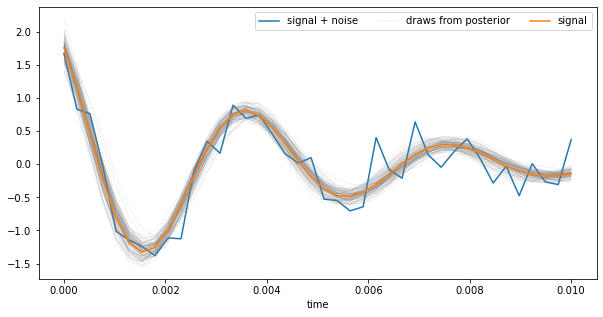

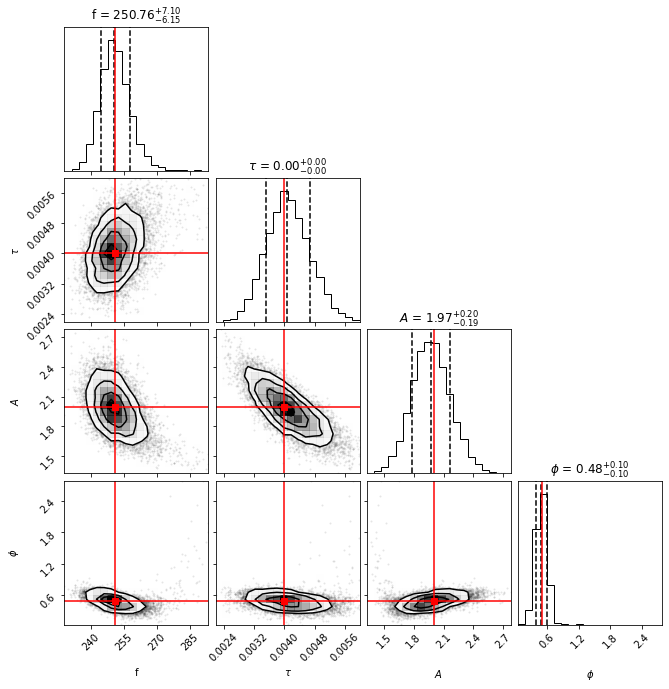

In [32]:
plt.figure(figsize=(10,5))
time = np.linspace(0,time_duration,num=signal_duration)
plt.plot(time,observation.numpy(),label='signal + noise')
for i in range(100):
    signal_params = samples.numpy()[i]
    if i == 0:
        plt.plot(time,damped_sinusoid_simulator(signal_params),lw=0.1,c='grey',label = 'draws from posterior')
    else:
        plt.plot(time,damped_sinusoid_simulator(signal_params),lw=0.1,c='grey')
plt.plot(time,damped_sinusoid_simulator(signal_inj_params),label = 'signal')
plt.legend(loc='best',ncol=3)
plt.xlabel('time')
fig = corner.corner(
    samples.numpy(),
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    truths=signal_inj_params,
    truth_color='red'
)

## Inference on multiple damped sinusoids

In [42]:
N_modes = 2
num_dim = 4*N_modes
amp_min, amp_max = 1.,10.
freq_min, freq_max = 100., 500
tau_min, tau_max = 2e-3, 6e-3
phi_min, phi_max = 0., 2*torch.pi
tensor_prior_min = torch.tensor([freq_min,tau_min,amp_min,phi_min]).repeat((N_modes))
tensor_prior_max = torch.tensor([freq_max,tau_max,amp_max,phi_max]).repeat((N_modes))
prior = utils.BoxUniform(low=tensor_prior_min, high=tensor_prior_max)

In [43]:
time_duration = 0.01
sampling_rate = 1./4096
signal_duration = int(time_duration/sampling_rate)

In [44]:
def noise_simulator():
    """
    This function simulate Gaussian white noise with amplitude 0.25 and duration = signal duration
    """
    return torch.randn(signal_duration) * 0.25

def damped_sinusoid_simulator(signal_params):
    """
    This function simulate a single sinusoid
        Arguments:
            signal_params: a list containing frequency, damping time, amplitude and phase of the sinusoid
    """
    freq = signal_params[0]
    tau = signal_params[1]
    amp = signal_params[2]
    phi = signal_params[3]
    t = torch.linspace(0,time_duration,steps=signal_duration)
    return amp*torch.cos(2.*torch.pi*freq*t + phi)*torch.exp(-t/tau)

def ringdown_simulator(signal_params):
    """
    This function simulate a ringdown signal as sum of damped sinusoids
        Arguments:
            amps: amplitudes of the damped sinusoids
            freqs: frequencies of the damped sinusoids
            taus: damping times of the damped sinusoids
            phases: phases of the damped sinusoids
    """
    return sum(list(map(damped_sinusoid_simulator,signal_params.reshape(N_modes,-1))))
    
def simulator(parameter_set):
    """
    This function generate a timeseries with signal and noise
        Arguments:
            parameter_set: parameters for the sinusoids
    """
    signal = ringdown_simulator(parameter_set)
    noise = noise_simulator()
    return signal+noise    

In [45]:
posterior = infer(simulator, prior, method="SNPE", num_simulations=100000)


Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]

 Neural network successfully converged after 296 epochs.

In [46]:
signal_inj_params = prior.sample()
observation = simulator(signal_inj_params)
samples = posterior.sample((10000,), x=observation)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [32]:
labels = [(f"f_{i}",f"tau_{i}",f"A_{i}",f"phi_{i}") for i in range(N_modes)]
labels = list(sum(labels, ()))

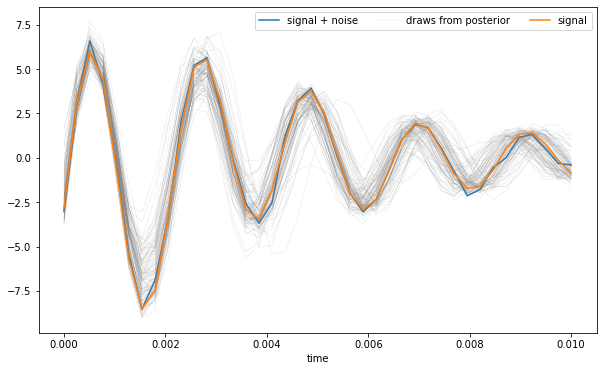

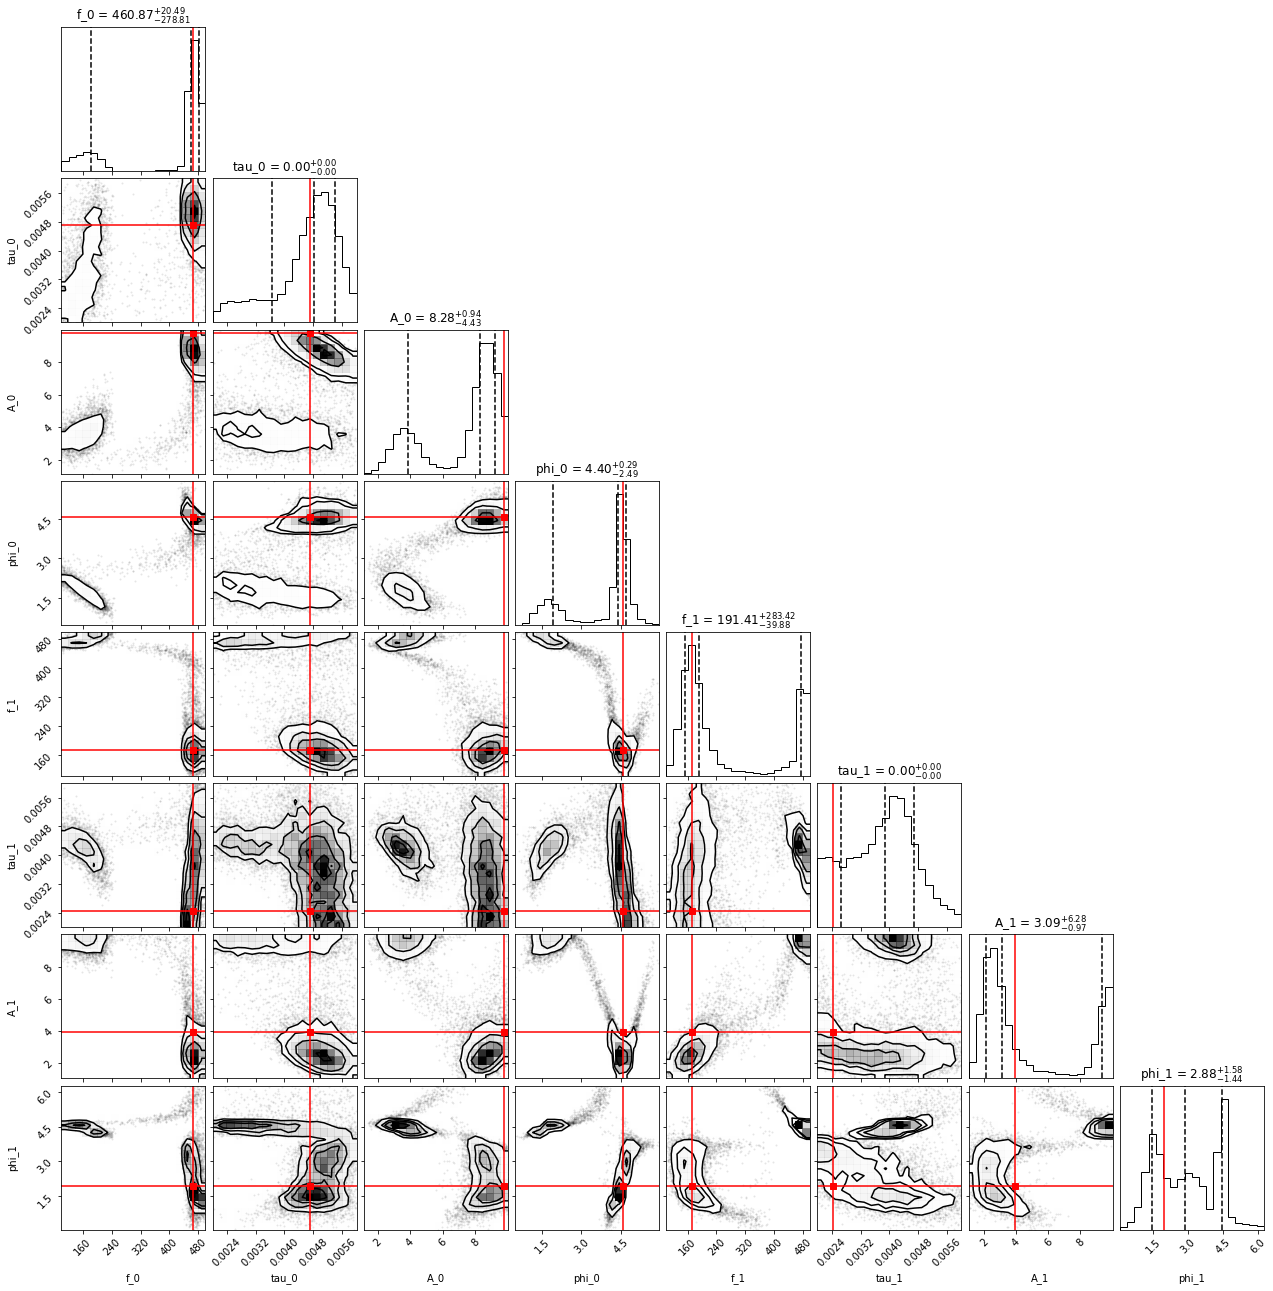

In [33]:
plt.figure(figsize=(10,6))
time = np.linspace(0,time_duration,num=signal_duration)
plt.plot(time,observation.numpy(),label='signal + noise')
for i in range(100):
    signal_params = samples.numpy()[i]
    if i == 0:
        plt.plot(time,ringdown_simulator(signal_params),lw=0.1,c='grey',label = 'draws from posterior')
    else:
        plt.plot(time,ringdown_simulator(signal_params),lw=0.1,c='grey')
plt.plot(time,ringdown_simulator(signal_inj_params),label = 'signal')
plt.legend(loc='best',ncol=3)
plt.xlabel('time')
fig = corner.corner(
    samples.numpy(),
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    truths=signal_inj_params,
    truth_color='red'
)

## Inference on final mass and spin using multiple modes

In [3]:
time_duration = 0.01
sampling_rate = 1./4096
signal_duration = int(time_duration/sampling_rate)

In [4]:
#modes =  [(2,2,0), (2,2,1), (2,1,0), (3,3,0), (3,3,1), (3,2,0)]
modes =  [(2,2,0),(2,2,1)]
qnm_interpolants = {}
for (l,m,n) in modes:
    interpolate_w_r, interpolate_w_i = qnm_interpolate(2,l,m,n)
    qnm_interpolants[(l,m,n)] = {'w_r': interpolate_w_r, 'w_i': interpolate_w_i}

* Interpolating ringdown complex frequencies of 2220 mode.
* Interpolating ringdown complex frequencies of 2221 mode.


/Users/rcotesta/miniconda3/envs/normalizing_flows/lib/python3.9/site-packages/pyRing/utils.py:56: UserWarning: The requested functionality requires data not included in the package. Please set a $PYRING_PREFIX variable which contains the path to such data. This can be done by setting 'export PYRING_PREFIX= yourpath' in your ~/.bashrc file. Typically, PYRING_PREFIX contains the path to the clone of the repository containing the source code.
  warnings.warn("The requested functionality requires data not included in the package. Please set a $PYRING_PREFIX variable which contains the path to such data. This can be done by setting 'export PYRING_PREFIX= yourpath' in your ~/.bashrc file. Typically, PYRING_PREFIX contains the path to the clone of the repository containing the source code.")


In [5]:
N_modes = len(modes)
amp_min, amp_max = 1.,10.
Mf_min, Mf_max = 20., 100.
af_min, af_max = 0.0, 0.99
phi_min, phi_max = 0., 2*torch.pi
prior_min_Mf_af = torch.tensor([Mf_min,af_min])
prior_max_Mf_af = torch.tensor([Mf_max,af_max])
prior_min_amps_phis = torch.tensor([amp_min,phi_min]).repeat((N_modes))
prior_max_amps_phis = torch.tensor([amp_max,phi_max]).repeat((N_modes))
prior_min = torch.cat((prior_min_Mf_af,prior_min_amps_phis))
prior_max = torch.cat((prior_max_Mf_af,prior_max_amps_phis))
prior = utils.BoxUniform(low=prior_min, high=prior_max)

In [6]:
def noise_simulator():
    """
    This function simulate Gaussian white noise with amplitude 0.25 and duration = signal duration
    """
    return torch.randn(signal_duration) * 0.25


def KerrMode_simulator(Mf,af,amp,phi,mode):
    """
    This function simulate the damped sinusoid of a Kerr black hole quasi-normal mode
        Arguments:
            Mf: mass of the black hole
            af: spin of the black hole
            amp: amplitude of the mode
            phi: phase of the mode
            mode: (l,m,n) set of the mode
    """
    freq = qnm_interpolants[mode]['w_r'](af)/(2.*torch.pi*lal.MTSUN_SI*Mf)
    tau = -(lal.MTSUN_SI*Mf)/qnm_interpolants[mode]['w_i'](af)
    t = torch.linspace(0,time_duration,steps=signal_duration)
    return amp*torch.cos(2.*torch.pi*freq*t + phi)*torch.exp(-t/tau)

def ringdown_simulator(signal_params):
    """
    This function simulate the ringdown of a Kerr black hole as sum of quasi-normal modes
    Arguments:
         signal_params: list including mass, spin of the black hole, and amplitudes and phases of the modes
    """
    Mf = signal_params[0]
    af = signal_params[1]
    amps = signal_params[2::2]
    phis = signal_params[3::2]
    return sum([KerrMode_simulator(Mf,af,amp,phase,mode) for amp,phase,mode in zip(amps,phis,modes)])
        
    
def simulator(parameter_set):
    """
    This function generate a timeseries with signal and noise
        Arguments:
            parameter_set: parameters for the sinusoids
    """
    signal = ringdown_simulator(parameter_set)
    noise = noise_simulator()
    return signal+noise    

In [10]:
posterior = infer(simulator, prior, method="SNPE", num_simulations=100000)

Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]

 Neural network successfully converged after 347 epochs.

In [7]:
# Open estimator
with open("./2_modes.pkl", "rb") as handle:
    posterior = pickle.load(handle)

In [8]:
signal_inj_params = torch.tensor([68,0.67,2,1.3,2.5,0.7])
#signal_inj_params = torch.tensor([68,0.67,2.,0.3])
observation = simulator(signal_inj_params)
samples = posterior.sample((100000,), x=observation)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [9]:
labels_amp_phi = [(f"A_{i}",f"phi_{i}") for i in range(N_modes)]
labels_amp_phi = list(sum(labels_amp_phi, ()))
labels = ["Mf","af"] + labels_amp_phi

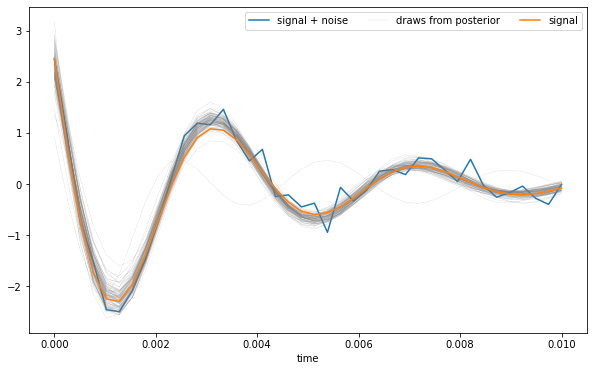

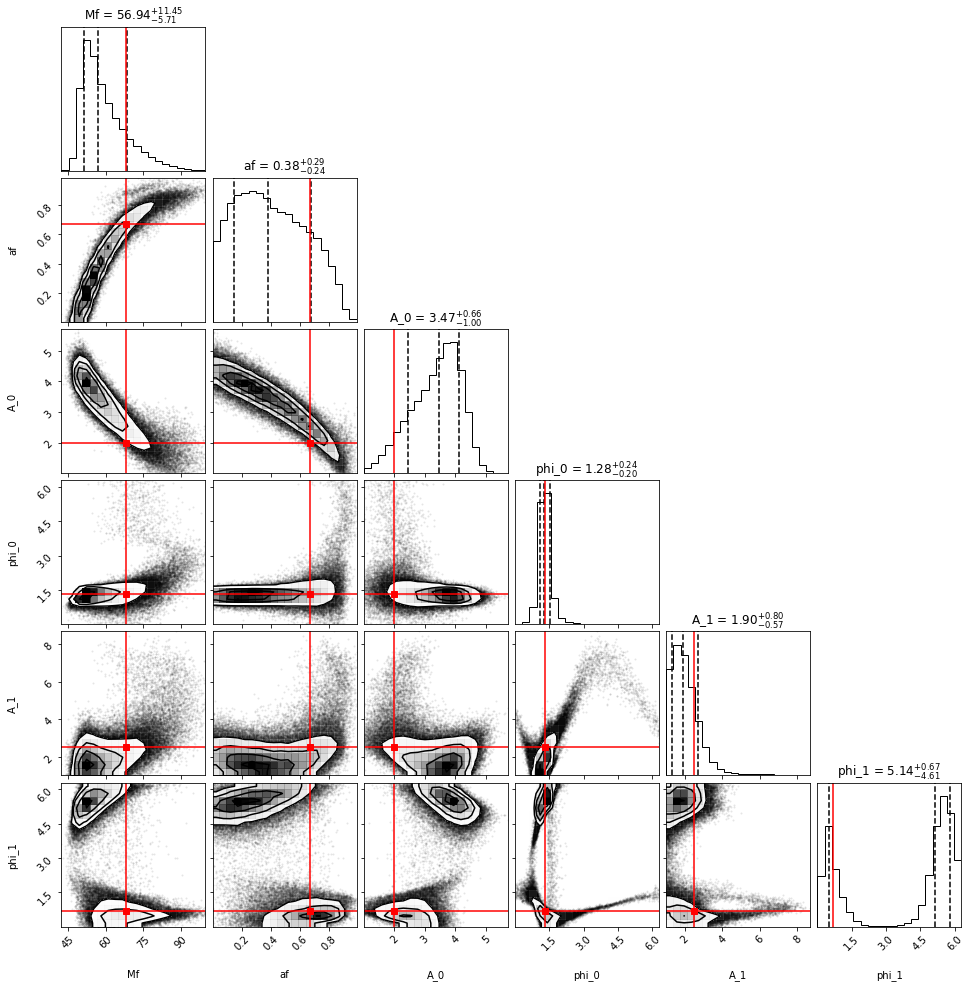

In [10]:
plt.figure(figsize=(10,6))
time = np.linspace(0,time_duration,num=signal_duration)
plt.plot(time,observation.numpy(),label='signal + noise')
for i in range(100):
    signal_params = samples.numpy()[i]
    if i == 0:
        plt.plot(time,ringdown_simulator(signal_params),lw=0.1,c='grey',label = 'draws from posterior')
    else:
        plt.plot(time,ringdown_simulator(signal_params),lw=0.1,c='grey')
plt.plot(time,ringdown_simulator(signal_inj_params),label = 'signal')
plt.legend(loc='best',ncol=3)
plt.xlabel('time')
fig = corner.corner(
    samples.numpy(),
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    truths=signal_inj_params,
    truth_color='red'
)